In [212]:
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import ucimlrepo

import xgboost as xgb
import sklearn

In [22]:
# Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

adult = ucimlrepo.fetch_ucirepo(id=2)
# adult_df = pd.DataFrame(adult)
Counter(adult.data.targets['income'])

Counter({'<=50K': 24720, '<=50K.': 12435, '>50K': 7841, '>50K.': 3846})

In [37]:
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [29]:
adult.data.targets.describe()

,income
count,48842
unique,4
top,<=50K
freq,24720


In [32]:
adult.data.features.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Get the training and validation data

In [67]:
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [205]:
categorical = [col for col in adult.data.features.columns if adult.data.features[col].dtype == 'object']
numerical = [col for col in adult.data.features.columns if adult.data.features[col].dtype != 'object']

features = adult.data.features.copy()
targets = adult.data.targets.copy()

# Replace any nan categories with '?'
features[categorical] = features[categorical].fillna('?')
features[categorical] = features[categorical].astype('category')

# Create mapping for all features from category to a numerical value
categories = {
    cat: sorted(features[cat].unique()) for cat in categorical
}

# Add '?' to every catgory as 0 index
categories = {cat: lst if lst[0] == '?' else ['?'] + lst for cat, lst in categories.items()}

features_numeric = features.copy()

# Replace the categories with their index positions
for col in categorical:
    features_numeric[col] = features[col].apply(lambda x: categories[col].index(x))

validation_mask = targets['income'].str.endswith('.')
low_mask = targets['income'].str.startswith('<')

targets_numeric = targets.copy()

# Replace the targets with binary classes
targets_numeric['income'][low_mask] = 0
targets_numeric['income'][~low_mask] = 1
targets_numeric['income'] = targets_numeric['income'].astype(bool)


# We can always grab the necessary data by running XXX[validation_mask]

# train_features = features_numeric[~validation_mask]
# train_targets = targets_numeric[~validation_mask]
# valid_features = features_numeric[validation_mask]
# valid_targets = targets_numeric[validation_mask]

In [186]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       48842 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      48842 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  48842 non-null  category
dtypes: category(8), int64(6)
memory usage: 2.6 MB


# Visualize the data

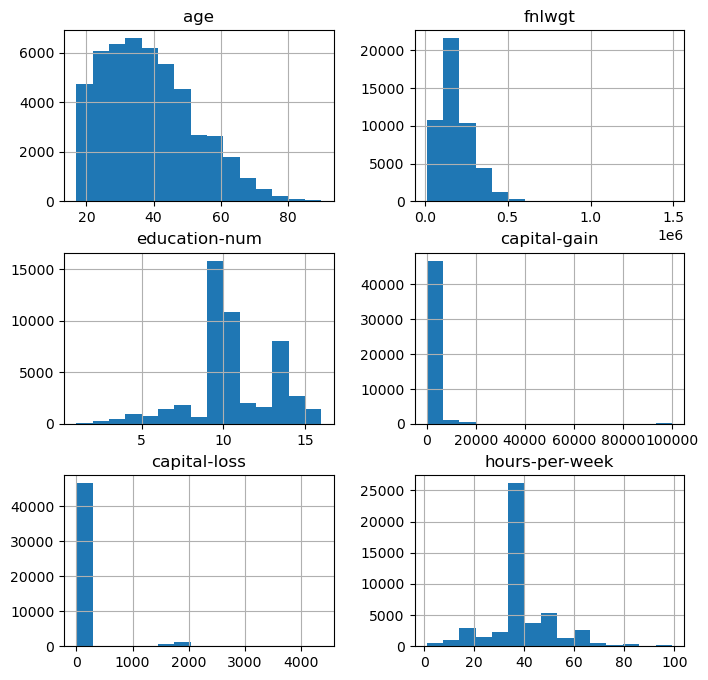

In [181]:
features_numeric.hist(bins=15, figsize=(8, 8));

array([[<Axes: title={'center': 'income'}>]], dtype=object)

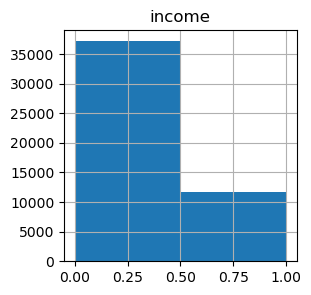

In [182]:
targets_numeric.astype(int).hist(bins=2, figsize=(3, 3))

# Make a GBDT model

In [232]:
params = {
    "model_params": {
        "n_estimators": 100,
        "max_depth": 4,
        "tree_method": "hist",
        "enable_categorical": True,
        'device': 'cuda',
        "eval_metric": [
            "logloss",
            "error",
            "auc",
            "aucpr",
            "map"
        ],
    },
    "train_params": {
        'verbose': False,
    }
}


clf = xgb.XGBClassifier(**params['model_params'])
clf.fit(features[~validation_mask], targets_numeric[~validation_mask],
        eval_set=[
            (features[~validation_mask], targets_numeric[~validation_mask]),
            (features[validation_mask], targets_numeric[validation_mask]),
        ],
        **params['train_params'],
       )
train_history = clf.evals_result()

[16:51:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/learner.cc:767: 
Parameters: { "device" } are not used.



Text(0.5, 1.0, 'Training Performance')

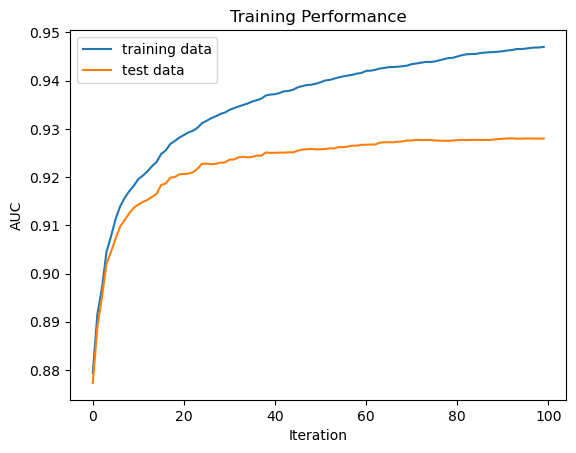

In [233]:
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["validation_0"]["auc"], label="training data")
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["validation_1"]["auc"], label="test data")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.title(f'Training Performance')

Text(0.5, 1.0, 'Training Performance')

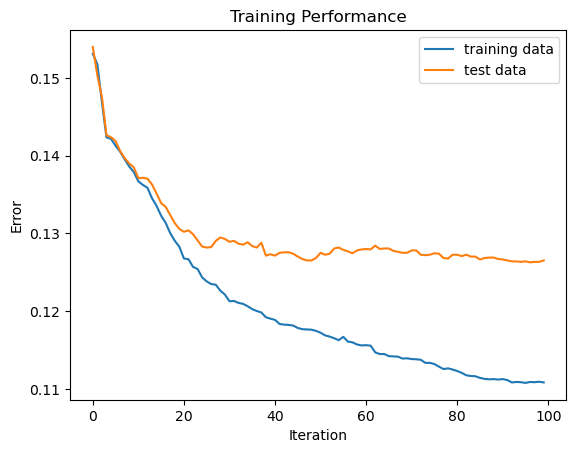

In [234]:
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["validation_0"]["error"], label="training data")
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["validation_1"]["error"], label="test data")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title(f'Training Performance')

Text(0.5, 1.0, 'ROC curve, AUC=(test: 0.9280, train: 0.9470)')

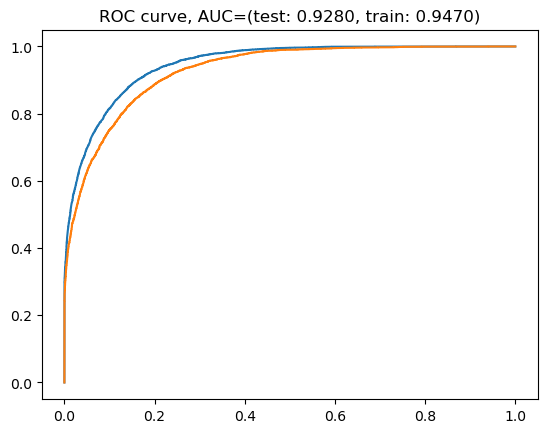

In [235]:
y_pred_proba_train = clf.predict_proba(features[~validation_mask])
y_pred_proba_valid = clf.predict_proba(features[validation_mask])

fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(targets_numeric[~validation_mask], y_pred_proba_train[:, 1])
fpr_valid, tpr_valid, _ = sklearn.metrics.roc_curve(targets_numeric[validation_mask], y_pred_proba_valid[:, 1])


auc_train = sklearn.metrics.auc(fpr_train, tpr_train)
auc_valid = sklearn.metrics.auc(fpr_valid, tpr_valid)

plt.plot(fpr_train, tpr_train, label="Training data")
plt.plot(fpr_valid, tpr_valid, label="Validation data")

plt.title(f"ROC curve, AUC=(test: {auc_valid:.4f}, train: {auc_train:.4f})")

# Make the TabTransformer